# Homework 3 solutions

We want to integrate the simple pendulum without the small angle approximation and compare different integration schemes.
Our system is:

\begin{align*}
   \dot{\theta} &= \omega \\
   \dot{\omega} &= -\frac{g}{L} \sin \theta
\end{align*}

where $\theta$ is the angular displacement from vertical and
$\omega$ is the angular velocity.  The angular acceleration in this
case is $\alpha = -(g/L) \sin\theta$.

```{note}
Just like with the orbits, the angular acceleration, $\alpha$, does not depend on (angular) velocity, $\omega$.
This means that we can use the symplectic integrators we looked at.
```

Our initial conditions are:

\begin{align*}
  \theta(t = 0) &= \theta_0 \\
  \omega(t = 0) &= 0
\end{align*}

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We'll do everything in a single class, `SimplePendulum`, which will only store the initial conditions.
The actual integration history will be created and returned by the integration methods contained
in `SimplePendulum`, which allows us to create a single object and then run each of the 3 integration
methods from it for comparison.

In [17]:
class SimplePendulum:
    """ manage and integrate a simple pendulum """

    def __init__(self, theta0, g=9.81, L=9.81):
        """we'll take theta0 in degrees and assume that the angular
        velocity is initially 0"""
        
        # initial condition
        self.theta0 = np.radians(theta0)

        self.g = g
        self.L = L

    def energy(self, theta_vec, omega_vec):
        """ given a solution, return the energy (per unit mass) """
        return (0.5 * self.L**2 * omega_vec**2 -
                self.g * self.L * np.cos(theta_vec))

    def period(self):
        """ return an estimate of the period, up to the theta**2 term """
        return (2.0 * np.pi * np.sqrt(self.L / self.g) *
                (1.0 + self.theta0**2 / 16.0 +
                 11.0 * self.theta0**4 / 3072.0))

    def rhs(self, theta, omega):
        """ equations of motion for a pendulum
              dtheta/dt = omega
              domega/dt = - (g/L) sin theta """

        return np.array([omega, -(self.g / self.L) * np.sin(theta)])

    def integrate_ec(self, dt, tmax):
        """integrate the equations of motion using the Euler-Cromer method"""

        # initial conditions
        t = 0.0

        t_s = [t]
        theta_s = [self.theta0]
        omega_s = [0.0]

        while t < tmax:

            dt = min(dt, tmax-t)
            
            # initial state
            theta = theta_s[-1]
            omega = omega_s[-1]
            
            # get the RHS
            thetadot, omegadot = self.rhs(theta, omega)

            # advance
            omega_new = omega + dt * omegadot
            theta_new = theta + dt * omega_new

            t += dt

            # store
            t_s.append(t)
            theta_s.append(theta_new)
            omega_s.append(omega_new)

        return np.array(t_s), np.array(theta_s), np.array(omega_s)
    
    def integrate_vv(self, dt, tmax):
        """integrate the equations of motion using velocity Verlet method"""

        # initial conditions
        t = 0.0

        t_s = [t]
        theta_s = [self.theta0]
        omega_s = [0.0]

        while t < tmax:

            dt = min(dt, tmax-t)
            
            # initial state
            theta = theta_s[-1]
            omega = omega_s[-1]
            
            # get the RHS at time-level n
            thetadot, omegadot = self.rhs(theta, omega)

            omega_half = omega + 0.5 * dt * omegadot
                
            theta_new = theta + dt * omega_half

            # get the RHS with the updated theta -- omega doesn't matter
            # here, since we only need thetadot and omega doesn't affect
            # that.
            _, omegadot_new = self.rhs(theta_new, omega)
            omega_new = omega_half + 0.5 * dt * omegadot_new

            t += dt

            # store
            t_s.append(t)
            theta_s.append(theta_new)
            omega_s.append(omega_new)

        return np.array(t_s), np.array(theta_s), np.array(omega_s)

    def integrate_rk4(self, dt, tmax):
        """integrate the equations of motion using 4th order Runge Kutta"""

        # initial conditions
        t = 0.0

        t_s = [t]
        theta_s = [self.theta0]
        omega_s = [0.0]

        while t < tmax:

            dt = min(dt, tmax-t)
            
            # initial state
            theta = theta_s[-1]
            omega = omega_s[-1]
            
            # get the RHS at time-level n
            thetadot1, omegadot1 = self.rhs(theta, omega)

            theta_tmp = theta + 0.5 * dt * thetadot1
            omega_tmp = omega + 0.5 * dt * omegadot1

            thetadot2, omegadot2 = self.rhs(theta_tmp, omega_tmp)

            theta_tmp = theta + 0.5 * dt * thetadot2
            omega_tmp = omega + 0.5 * dt * omegadot2

            thetadot3, omegadot3 = self.rhs(theta_tmp, omega_tmp)

            theta_tmp = theta + dt * thetadot3
            omega_tmp = omega + dt * omegadot3

            thetadot4, omegadot4 = self.rhs(theta_tmp, omega_tmp)

            theta_new = theta + dt / 6.0 * (thetadot1 + 2.0 * thetadot2 +
                                            2.0 * thetadot3 + thetadot4)
            omega_new = omega + dt / 6.0 * (omegadot1 + 2.0 * omegadot2 +
                                            2.0 * omegadot3 + omegadot4)

            t += dt

            # store
            t_s.append(t)
            theta_s.append(theta_new)
            omega_s.append(omega_new)

        return np.array(t_s), np.array(theta_s), np.array(omega_s)

Let's try it out

## Case 1: $\theta_0 = 10^\circ$

In [18]:
# initial angle in degrees -- the class converts to radians
theta0 = 10

p10 = SimplePendulum(theta0)
period = p10.period()
print(f"{period=}")

period=6.295168481931661


Euler-Cromer method

In [19]:
# fixed timestep
dt = period / 20
tmax = 10 * period

In [20]:
t_ec, theta_ec, omega_ec = p10.integrate_ec(dt, tmax)

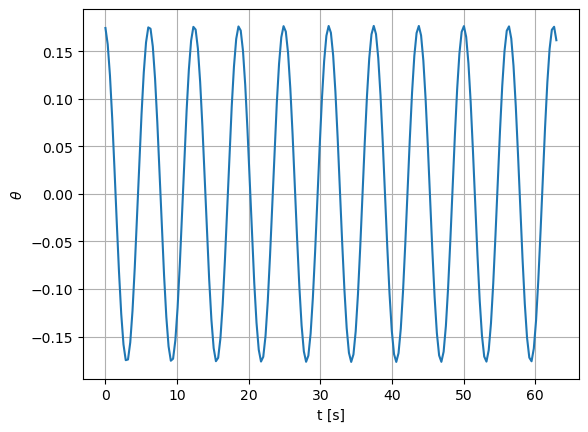

In [21]:
fig, ax = plt.subplots()
ax.plot(t_ec, theta_ec, label="Euler-Cromer")

ax.set_xlabel("t [s]")
ax.set_ylabel(r"$\theta$")

ax.grid()

now velocity-Verlet

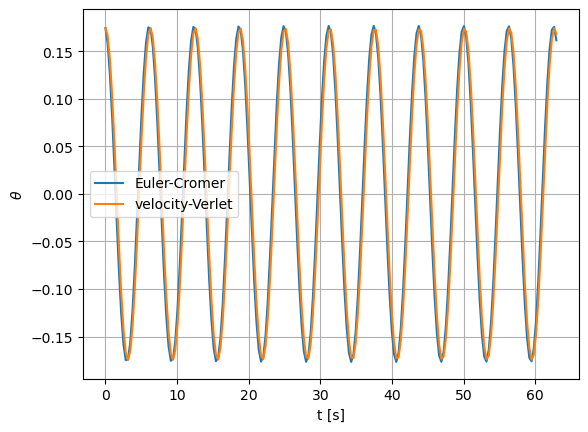

In [22]:
t_vv, theta_vv, omega_vv = p10.integrate_vv(dt, tmax)

ax.plot(t_vv, theta_vv, label="velocity-Verlet")
ax.legend()
fig

and finally 4th-order Runge-Kutta

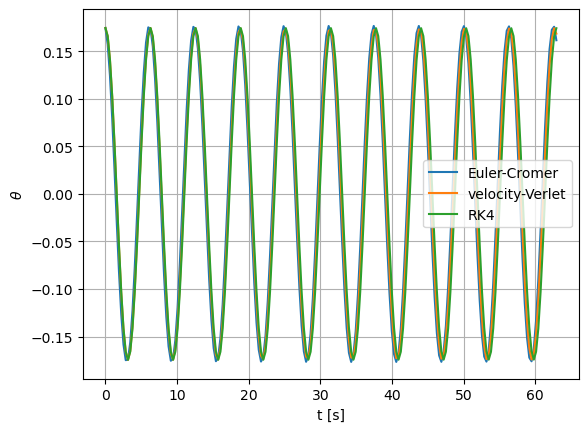

In [23]:
t_rk4, theta_rk4, omega_rk4 = p10.integrate_rk4(dt, tmax)

ax.plot(t_rk4, theta_rk4, label="RK4")
ax.legend()
fig

All the curves are quite close, but we see by the end there are some differences.

Let's run for 100 periods and look at the last 10

In [24]:
tmax *= 10
t_ec2, theta_ec2, omega_ec2 = p10.integrate_ec(dt, tmax)
t_vv2, theta_vv2, omega_vv2 = p10.integrate_vv(dt, tmax)
t_rk42, theta_rk42, omega_rk42 = p10.integrate_rk4(dt, tmax)

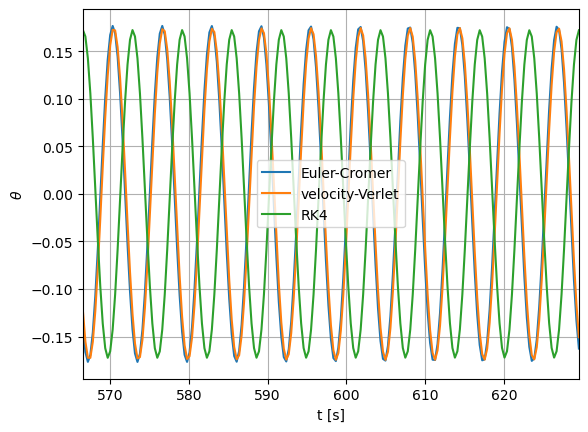

In [25]:
fig, ax = plt.subplots()
ax.plot(t_ec2, theta_ec2, label="Euler-Cromer")
ax.plot(t_vv2, theta_vv2, label="velocity-Verlet")
ax.plot(t_rk42, theta_rk42, label="RK4")

ax.set_xlabel("t [s]")
ax.set_ylabel(r"$\theta$")
ax.set_xlim(90*period, 100*period)
ax.legend()
ax.grid()

So we see that after a while, the two symplectic integrators stay in phase, but the RK4 integrator is completely out of phase.

Let's look at energy for the original (10 periods) runs

Text(0, 0.5, 'E/m')

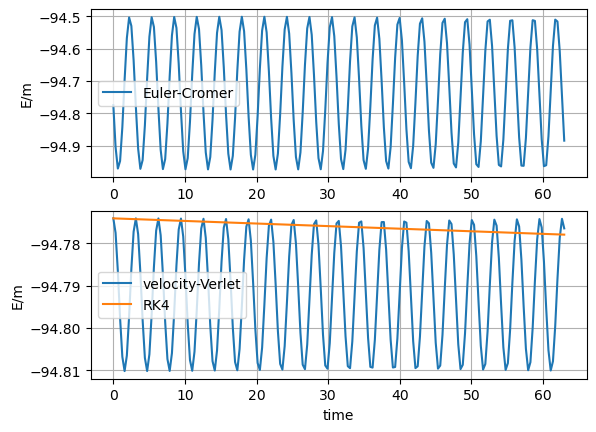

In [27]:
E_ec = p10.energy(theta_ec, omega_ec)
E_vv = p10.energy(theta_vv, omega_vv)
E_rk4 = p10.energy(theta_rk4, omega_rk4)

fig = plt.figure()

ax1 = fig.add_subplot(211)
ax1.plot(t_ec, E_ec, label="Euler-Cromer")
ax1.grid()
ax1.legend()
ax1.set_ylabel("E/m")

ax2 = fig.add_subplot(212)
ax2.plot(t_vv, E_vv, label="velocity-Verlet")
ax2.plot(t_rk4, E_rk4, label="RK4")
ax2.grid()
ax2.legend()
ax2.set_xlabel("time")
ax2.set_ylabel("E/m")

These are plotted on different scales since the Euler-Cromer method has much larger swings in the energy.  But note that for both the Euler-Cromer and velocity-Verlet methods, the energy stays bounded and returns back to its original value each period.

For the 4th-order Runge-Kutta, there is a steady drift in the total energy.

## Case 2: $\theta_0 = 100^\circ$

In [28]:
theta0 = 100

p100 = SimplePendulum(theta0)
period = p100.period()
print(f"{period=}")

period=7.688181618459404


Notice that the period here is very different than the classic small-angle approximation period.

In [29]:
# fixed timestep
dt = period / 20
tmax = 10 * period

In [30]:
t_ec, theta_ec, omega_ec = p100.integrate_ec(dt, tmax)
t_vv, theta_vv, omega_vv = p100.integrate_vv(dt, tmax)
t_rk4, theta_rk4, omega_rk4 = p100.integrate_rk4(dt, tmax)

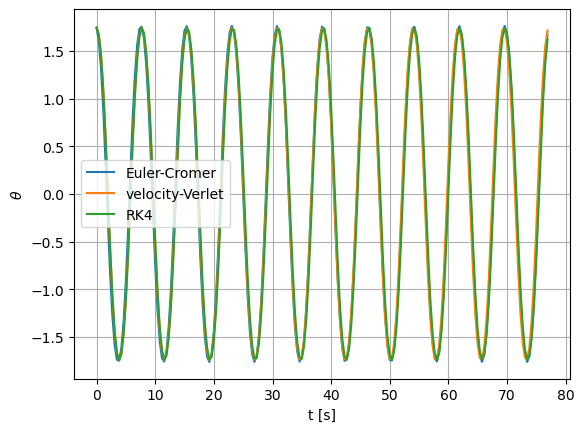

In [31]:
fig, ax = plt.subplots()

ax.plot(t_ec, theta_ec, label="Euler-Cromer")
ax.plot(t_vv, theta_vv, label="velocity-Verlet")
ax.plot(t_rk4, theta_rk4, label="RK4")

ax.legend()
ax.set_xlabel("t [s]")
ax.set_ylabel(r"$\theta$")

ax.grid()

Again, the Euler-Cromer and velocity-Verlet methods track nicely

We'll split the energy plot into 2 so we can better see the trends

Text(0, 0.5, 'E/m')

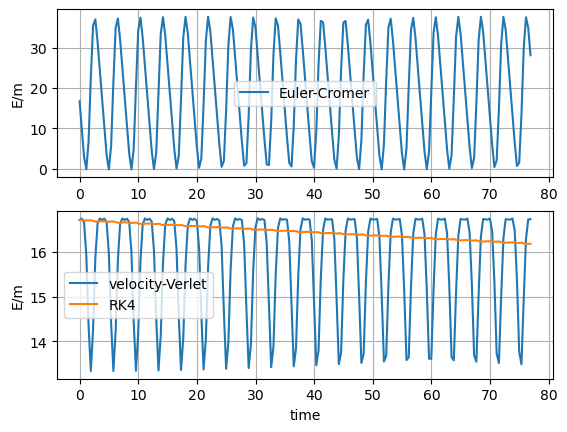

In [33]:
E_ec = p100.energy(theta_ec, omega_ec)
E_vv = p100.energy(theta_vv, omega_vv)
E_rk4 = p100.energy(theta_rk4, omega_rk4)

fig = plt.figure()
ax1 = fig.add_subplot(211)

ax1.plot(t_ec, E_ec, label="Euler-Cromer")
ax1.legend()
ax1.grid()
ax1.set_ylabel("E/m")

ax2 = fig.add_subplot(212)
ax2.plot(t_vv, E_vv, label="velocity-Verlet")
ax2.plot(t_rk4, E_rk4, label="RK4")
ax2.legend()
ax2.grid()
ax2.set_xlabel("time")
ax2.set_ylabel("E/m")

We see that, again, the two sympletic integrators seem to conserve energy over the period, but the 4th order Runge-Kutta has a steady drift just like we saw in the earlier case.

## Convergence

We'll focus just on the larger amplitude.  In addition to making a plot, we'll also print out the difference between the minimum and maximum energy over the integration duration.  This will be our metric for assessing convergence.

20 : 37.873464677642545
40 : 18.69023944326237
80 : 9.314754417201456


Text(0, 0.5, 'E/m')

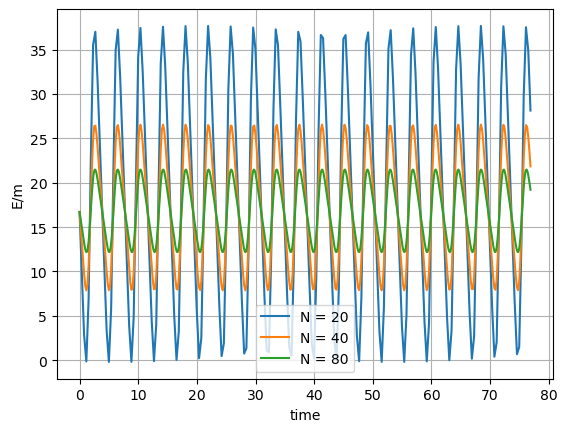

In [34]:
p = SimplePendulum(100)

fig, ax = plt.subplots()
for n in [20, 40, 80]:
    tau = p.period() / n
    t, theta, omega = p.integrate_ec(tau, 10*p.period())
    E = p.energy(theta, omega)
    ax.plot(t, p.energy(theta, omega), label=f"N = {n}")
    print(f"{n} : {E.max() - E.min()}")
ax.legend()
ax.grid()
ax.set_xlabel("time")
ax.set_ylabel("E/m")

Notice that when we print out the amplitude of the energy, it decreases by a factor of 2 each time we double $N$---this is first-order convergence.

20 : 3.4088291065175973
40 : 0.8483208900033361
80 : 0.21185146597349913


Text(0, 0.5, 'E/m')

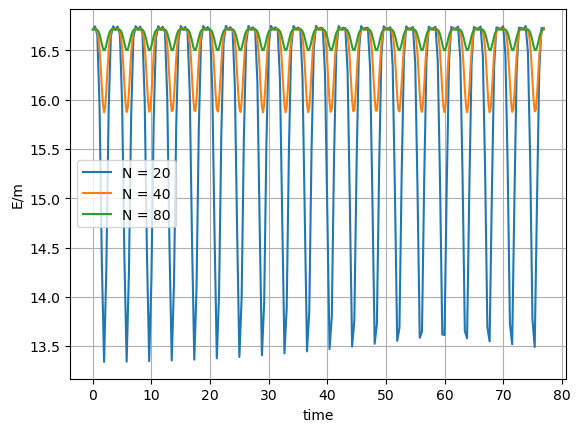

In [35]:
p = SimplePendulum(100)

fig, ax = plt.subplots()
for n in [20, 40, 80]:
    tau = p.period() / n
    t, theta, omega = p.integrate_vv(tau, 10*p.period())
    E = p.energy(theta, omega)
    ax.plot(t, E, label=f"N = {n}")
    print(f"{n} : {E.max() - E.min()}")
ax.legend()
ax.grid()
ax.set_xlabel("time")
ax.set_ylabel("E/m")

Now notice that when we print out the amplitude of the energy change over the integration, it descreases by a factor of 4 each time we double $N$---this is 2nd-order convergence.

20 : 0.5346620582999186
40 : 0.017873506652158255
80 : 0.0005985955513878594


Text(0, 0.5, 'E/m')

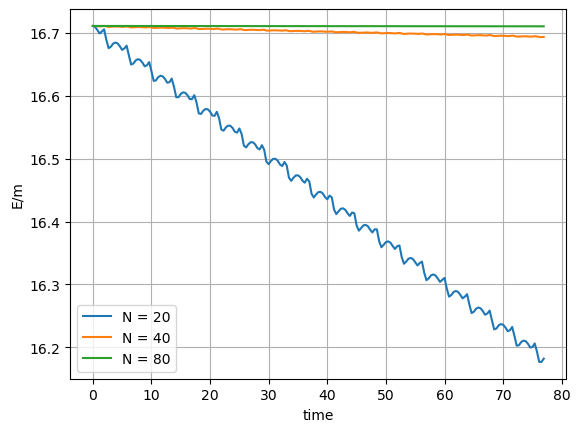

In [36]:
p = SimplePendulum(100)

fig, ax = plt.subplots()
for n in [20, 40, 80]:
    tau = p.period() / n
    t, theta, omega = p.integrate_rk4(tau, 10*p.period())
    E = p.energy(theta, omega)
    ax.plot(t, E, label=f"N = {n}")
    print(f"{n} : {E.max() - E.min()}")
ax.legend()
ax.grid()
ax.set_xlabel("time")
ax.set_ylabel("E/m")

This now seems to be converging better than 4th order, even though the solution is clearly not as good as the other methods.